# Simple Chemical Reaction in a closed Box.

In this Notebook, I will try to modelize a **really simple reaction**:

$Fe2O3 + CO \rightarrow Fe3O4 + C02$

Here the initial condition can be: 
- Concentration of $Fe2O3$: $c_1=?$ mol/l;
- Concentration of $CO$: $c_2=?$ mol/l;
- Concentration of $Fe3O4$: $c_3=?$ mol/l; 
- Concentration of $CO2$: $c_4=?$ mol/l; 



In [101]:
import numpy as np 
import matplotlib.pyplot as plt 
from models.StateSpaceModel import StateSpaceModel
from utils.chemical_reactions import define_kf

In [102]:
kfs = []
ts = np.arange(0, 100, 10)
vmat = np.arange(0, 10, 0.5)

for t in ts:
    kf = define_kf(vmat, t)
    kfs.append(kf)

kfs = np.array(kfs)
kfs = kfs.T

In [103]:
kfs.shape, vmat.shape, ts.shape

((20, 10), (20,), (10,))

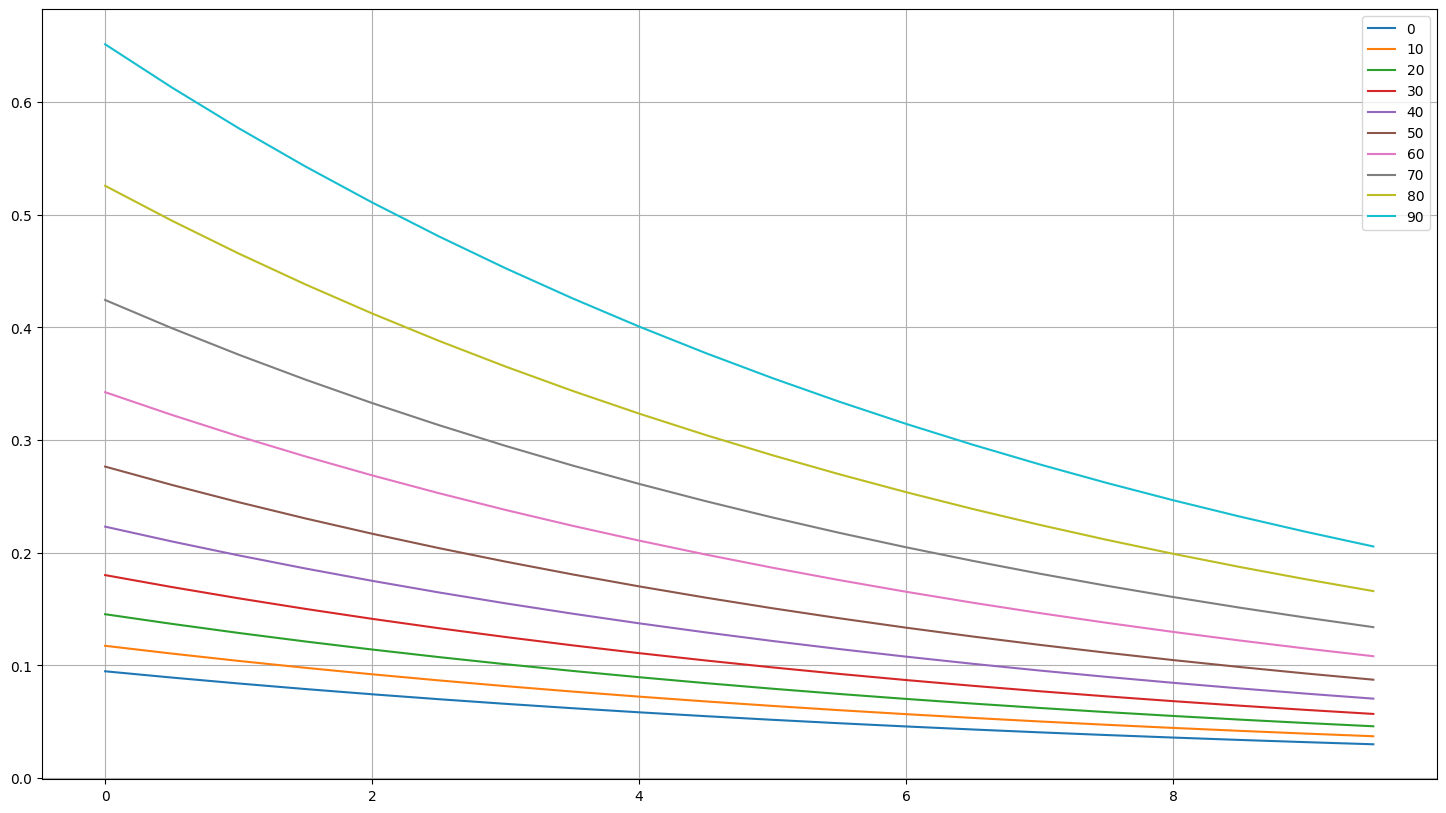

In [104]:
plt.figure(figsize=(18, 10))

plt.plot(vmat, kfs, label=ts)

plt.grid()
plt.legend()

In [105]:
# Define parameter for the control volume.
height_step = 10e-3 # 10 cm height step as the temperature simulator.
heart_radius = 1 # 5 metter heart radius.
control_section = np.pi * heart_radius**2
delta_t = 1e-3 # 1 ms time step. Because the gas is realy fast !.. 
temperature = 20 # °C
material_velocity = 0.1 # in m.s^-1

strength = 5
save_folder = f'ssm_dataset/strength0{strength}'

rho = control_section* material_velocity
# Define initial conditions!
# consentrations in mol/l * control_volume = mol
c1 = 0.5 # mol/m^3
c2 = 5.0 # mol/m^3
c3 = 0  # mol/m^3
c4 = 0  # mol/m^3

# Integrate the derivatve of the concentrations
# These will define what is going in and what is going out. 
# We will also multiply this concentration par un volume. pour avoir le nombre de mol. 
gas_velocity = 15 # m.s-1
solid_velocity = 1e-3 # m.s-1
gas_flow_rate = gas_velocity*control_section # m^3.s^-1
solid_flow_rate = solid_velocity*control_section # m^3.s^-1

c1_dot = solid_flow_rate* c1 # mol.s^-1
c2_dot = gas_flow_rate* c2 # mol.s^-1
c3_dot = solid_flow_rate* c3 # mol.s^-1
c4_dot = gas_flow_rate* c4 # mol.s^-1

kf = define_kf(material_velocity, temperature)
print('kf', kf)
print('rho', rho)

kf 0.14360134074973427
rho 0.3141592653589793


In [106]:
X_INIT = np.array([[c1],
                   [c2],
                   [0.],
                   [0.]])

A = np.array([[3*rho*kf-3*kf , 0., 0., 0.],
              [0., rho*kf-kf, 0., 0.],
              [2*kf-2*rho*kf, 2*kf-2*rho*kf, 0.,0.],
              [kf-rho*kf, kf-rho*kf, 0.,0.]])

const = rho
print(rho**2)
print(const)
B = np.array([[const, 0., 0., 0.],
           [0., const, 0., 0.],
           [0., 0., const, 0.],
           [0., 0., 0., const]])


C = np.identity(4)

D = np.array([[0., 0., 0., 0.]])

U = np.array([[0.],
              [0.], 
              [0.], 
              [0.]])

Ue = np.array([[0.],
               [0.],
               [0.],
               [0.]])

Xe = np.array([[0.],
               [0.],
               [0.],
               [0.]])


ssm = StateSpaceModel(A, B, C, D, X_INIT, Xe, Ue, rho)

0.09869604401089357
0.3141592653589793


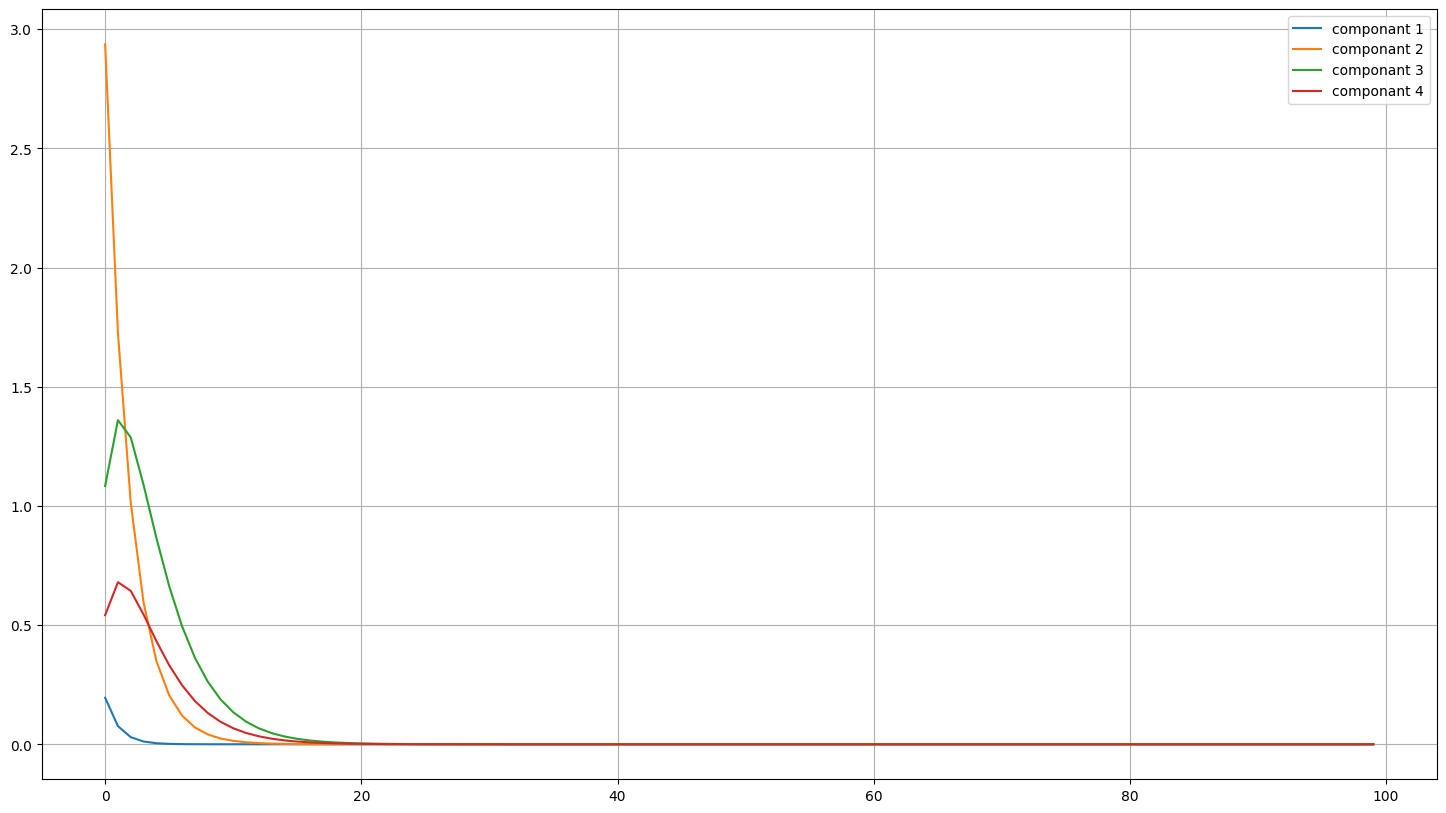

In [107]:
free_output = []
for i in range(100):
    output = ssm(U)
    free_output.append(output)

free_output = np.array(free_output)

plt.figure(figsize=(18, 10))
for i in range(4):
    # plt.subplot(4, 1, i+ 1)
    plt.plot(free_output[:, i], label=f"componant {i+1}")

plt.grid()
plt.legend()

In [108]:
Us = np.zeros((100, 4, 1))

Us[25:50, 0, 0] = 0.5
Us[25:50, 1, 0] = 0.5

In [109]:
ssm = StateSpaceModel(A, B, C, D, X_INIT, Xe, Ue, rho)

outputs = []
for i in range(100):
    u = Us[i]
    out = ssm(u)
    outputs.append(out)
    print(f"\r {out[0]}; {out[1]}; {out[2]}; {out[3]}", end="")

outputs = np.array(outputs)

 [9.66749627e-22]; [1.06048195e-12]; [8.62900764e-09]; [4.31450382e-09]

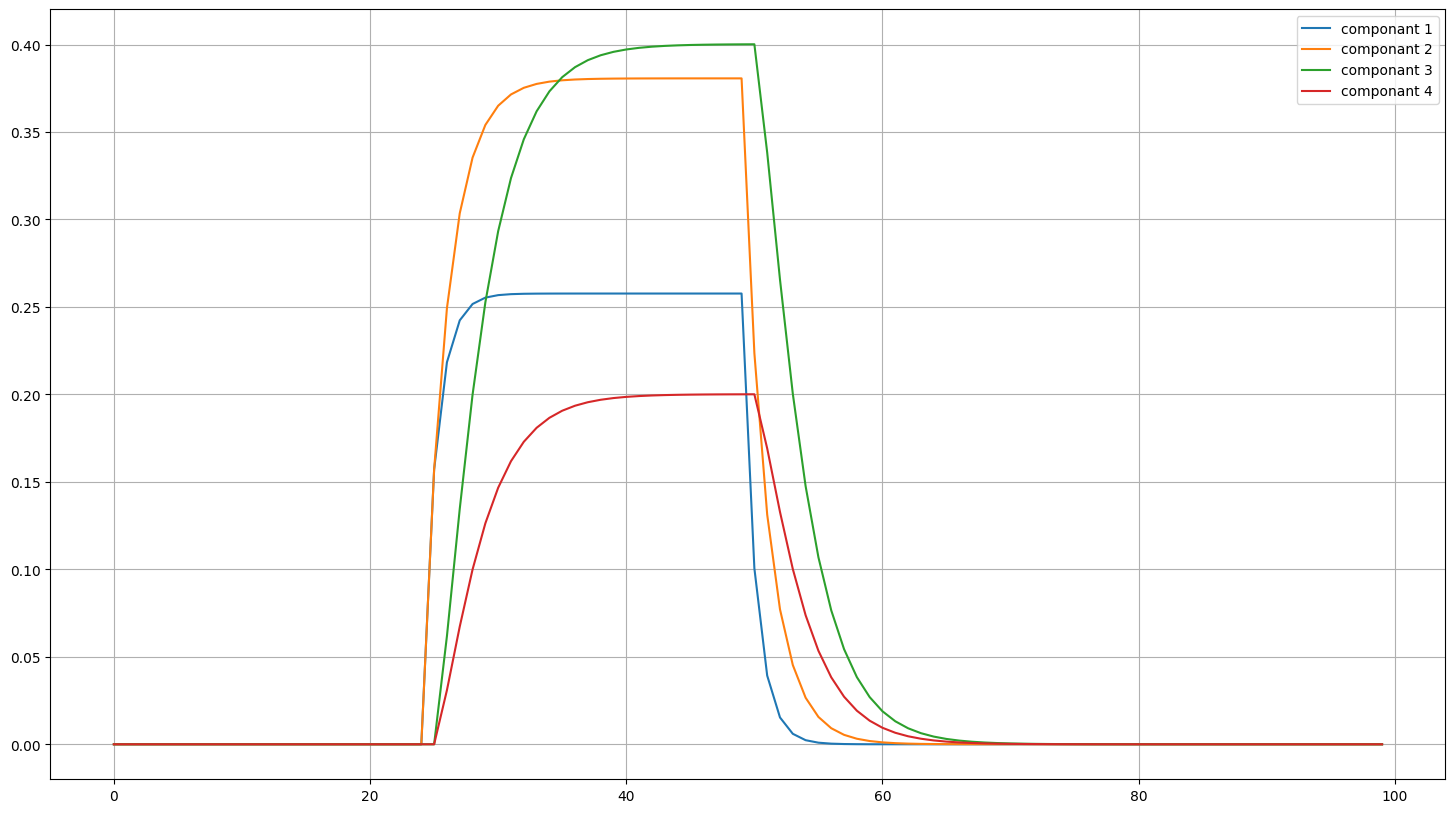

In [110]:
plt.figure(figsize=(18, 10))

for i in range(4):
    # plt.subplot(4, 1, i+ 1)
    plt.plot(outputs[:, i], label=f"componant {i+1}")
plt.grid()
plt.legend()

# Let's make the Source Domain Dataset
The Goal to the classification is to make a Classification task:
- The model will have the `componant 1`, `componant 2`, `componant 3`, `componant 4` Time Series.
- The model will be asked to classify the depending on "which temperature the reaction are occuring?"
    - $T_1 \in [20, 39]$ 
    - $T_4 \in [40, 59]$ 
    - $T_3 \in [60, 79]$ 
    - $T_4 \in [80, 99]$ 



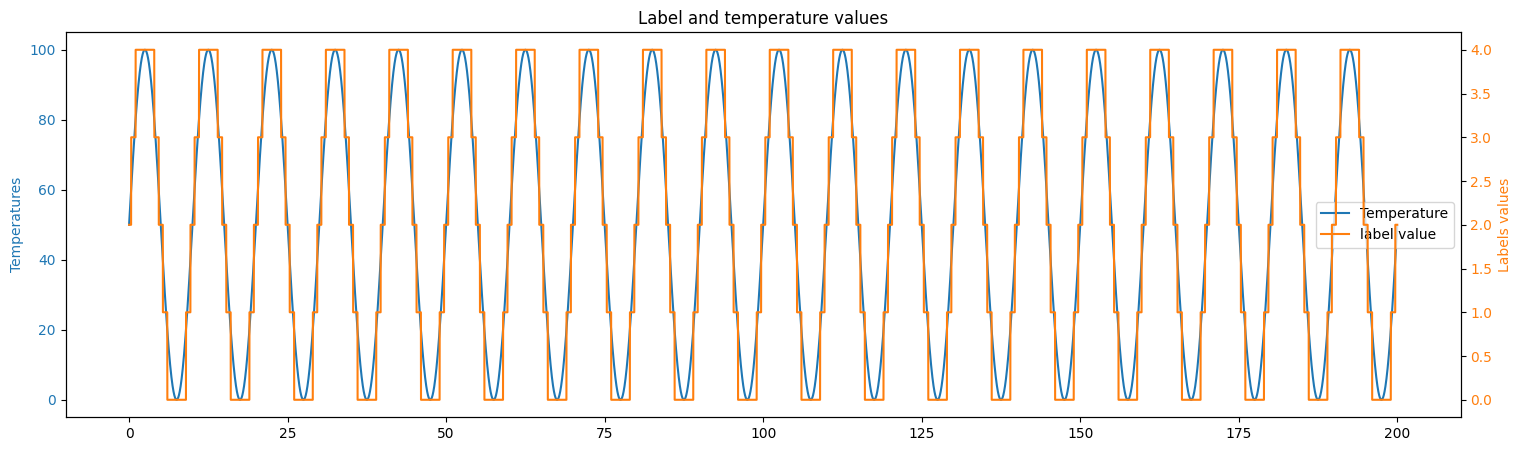

In [111]:
t = np.arange(0, 200, 0.01)

amplitude = 50
f= 0.1
temperatures = amplitude* np.sin(2* np.pi* f* t) + 50

labels = np.zeros_like(temperatures)
# print((temperatures >= 20.) & (temperatures <= 39.))

labels[(temperatures > 20.) & (temperatures <= 40.)] = 1.
labels[(temperatures > 40.) & (temperatures <= 60.)] = 2.
labels[(temperatures > 60.) & (temperatures <= 80.)] = 3.
labels[(temperatures > 80.) & (temperatures <= 100)] = 4.

plt.figure(figsize=(18, 5))
plt.title("Label and temperature values")
ax = plt.subplot(111)
lns1 = ax.plot(t, temperatures, label="Temperature")
color = "tab:blue"
ax.set_ylabel('Temperatures', color=color)
ax.tick_params(axis='y', labelcolor=color)



ax2 = plt.twinx()
color= "tab:orange"
lns2 = ax2.plot(t, labels, label="label value", color=color)
ax2.set_ylabel('Labels values', color=color)
ax2.tick_params(axis='y', labelcolor=color)



lines = lns1+ lns2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc=0)

# ax.grid()

# Make the inputs

In [112]:
fc1 = 1
# noise1 = np.random.normal(size=t.shape[0], scale=0.20)
mean = c1
c1_in = c1+ c1*np.sin(2*np.pi*fc1*t) + c1*(strength/5)

fc2 = 2
# noise2 = np.random.normal(size=t.shape[0], scale=0.20)
c2_in = c2+ c2*np.sin(2*np.pi*fc2*t) + c2*(strength/5)

# Define the velocity thanks to time
fvc = 0.5
vc = material_velocity + 0.3*material_velocity* np.sin(2*np.pi*fvc*t) + material_velocity

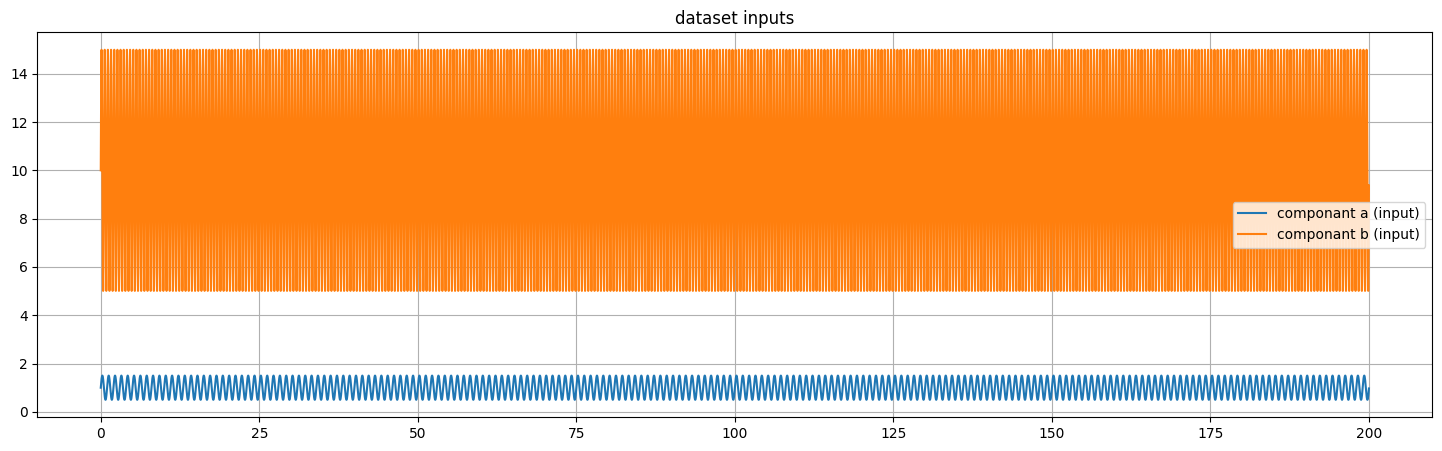

In [113]:
plt.figure(figsize=(18, 5))
plt.title("dataset inputs")
plt.plot(t, c1_in, label="componant a (input)")
plt.plot(t, c2_in, label="componant b (input)")
plt.legend()
plt.grid()


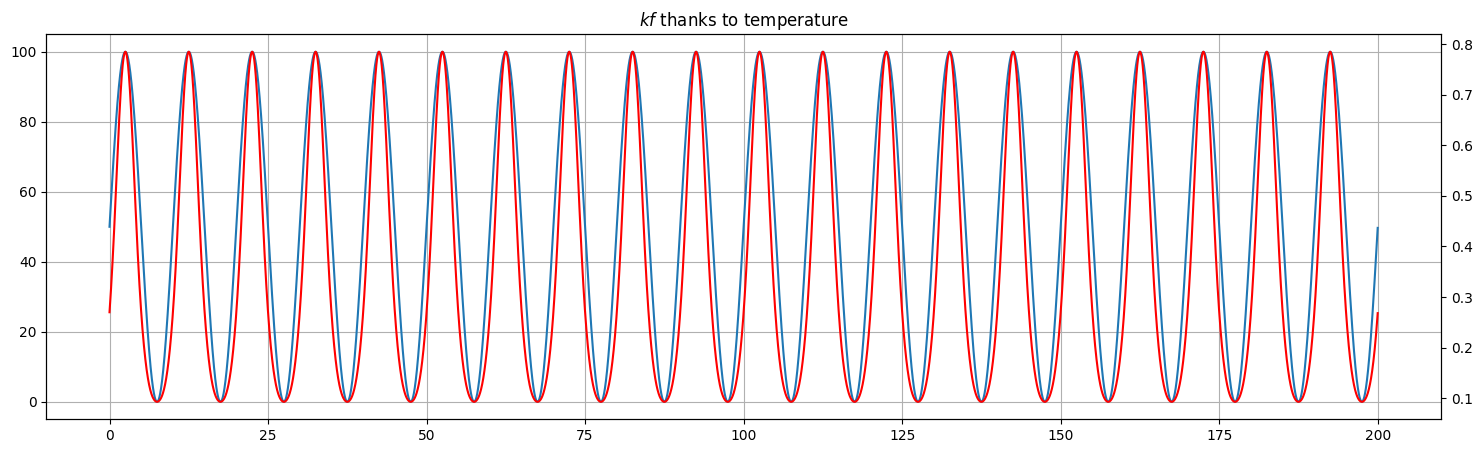

In [114]:
# Deine kf thanks to varying parameters.
rhos = control_section*vc
kfs = []
for _vc, _temp in zip(vc, temperatures):
    kfs.append(define_kf(_vc, _temp))

plt.figure(figsize=(18, 5))
plt.title('$kf$ thanks to temperature')
plt.plot(t, temperatures)
plt.grid()
plt.twinx()
plt.plot(t, kfs, color="r")

In [115]:
outputs = []

dataset_generator =StateSpaceModel(A, B, C, D, X_INIT, Xe, Ue, rho)
dataset_generator.update_matrices(kfs[0], rhos[0])

for _kf, _rho, in_c1, in_c2 in zip(kfs, rhos, c1_in, c2_in):
    _u = np.array([[in_c1],
                   [in_c2], 
                   [0.], 
                   [0.]])
    dataset_generator.update_matrices(_kf, _rho)
    _outs = dataset_generator(_u)
    outputs.append(_outs.reshape((-1,)))

outputs = np.array(outputs) 

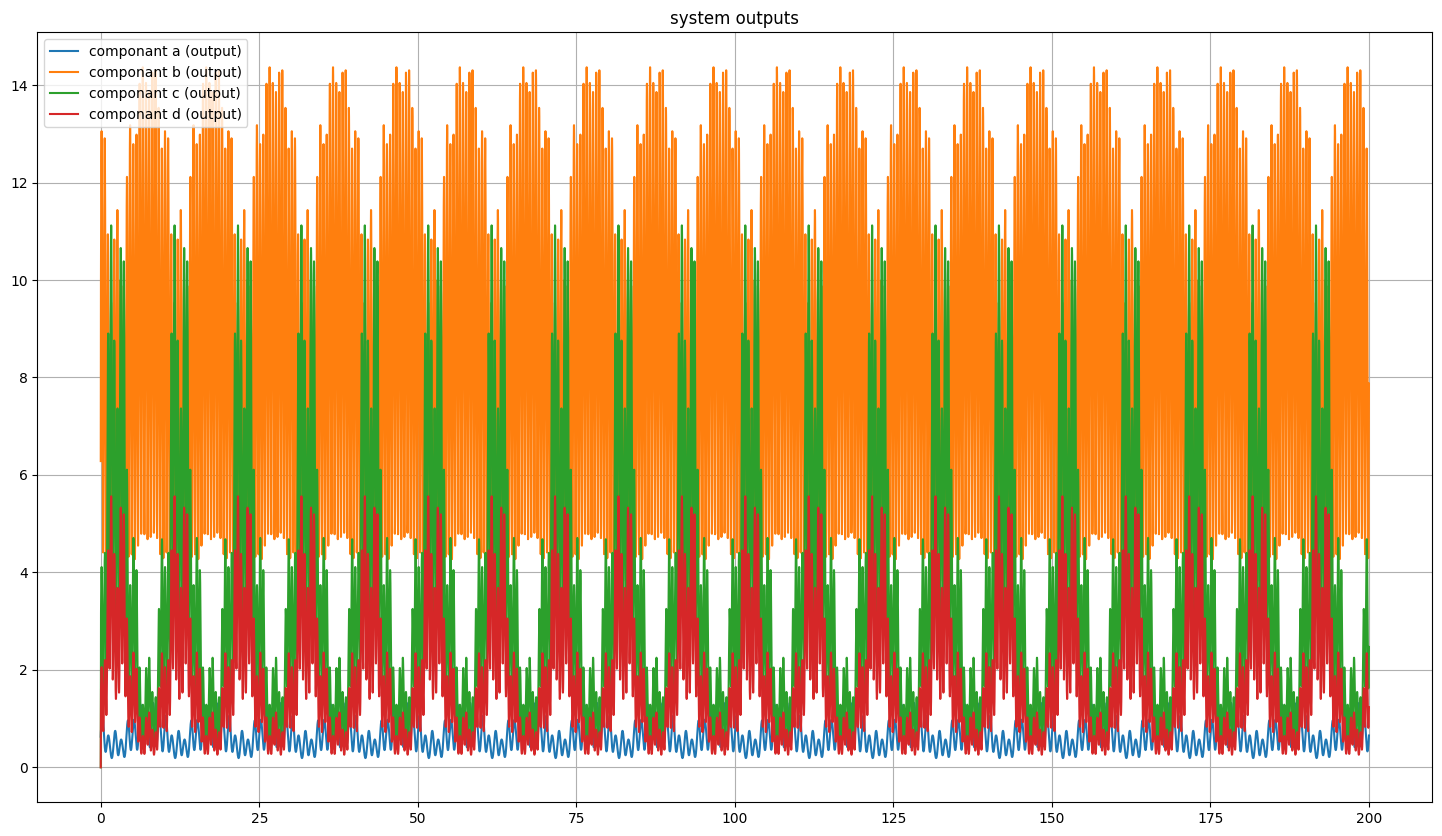

In [116]:
letters = ["a", "b", "c", "d"]

plt.figure(figsize=(18, 10))
plt.title('system outputs')
for i in range(4):
    plt.plot(t, outputs[:, i], label=f"componant {letters[i]} (output)")
plt.grid()
plt.legend()


In [117]:
outputs.shape

(20000, 4)

In [118]:
inputs = np.array([c1_in, c2_in]).T

data = np.hstack((inputs, outputs, vc.reshape((-1, 1)), labels.reshape((-1, 1))))

In [119]:
inputs.shape, outputs.shape, data.shape

((20000, 2), (20000, 4), (20000, 8))

In [120]:
import pandas as pd

cols = ["in_c1", "in_c2", "out_c1", "out_c2", "out_c3", "out_c4", "material velocity", "labels"]

df = pd.DataFrame(data, columns=cols)

df.to_hdf(f"{save_folder}/05 - Shift in Mean.h5", key="data")
